<a href="https://colab.research.google.com/github/dominiksakic/zero_to_hero/blob/main/basics_05_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# BOILER PLATE

!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

--2025-07-07 11:05:02--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2025-07-07 11:05:02 (15.0 MB/s) - ‘names.txt’ saved [228145/228145]



In [2]:

words = open('names.txt', 'r').read().splitlines()

# build vocab and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)


# build the dataset
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [3]:
class Linear:
  def __init__(self,fan_in, fan_out, bias=True):
    self.weight = torch.randn(fan_in, fan_out) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out =  x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class Batch1DNorm:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.training = True
    self.momentum = momentum
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0, 1)
      else:
        raise ValueError(f"Unsupported input shape {x.shape}")
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.running_mean * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.running_mean * xvar

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n, C * self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [4]:
seed = 42
torch.manual_seed(seed)

In [ ]:
n_embd = 10
n_hidden = 200

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), Batch1DNorm(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])


# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum((p.nelement() for p in parameters)))
for p in parameters:
  p.requires_grad = True

170897


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/ 200000: 3.5315
  10000/ 200000: 1.8400
  20000/ 200000: 1.8407
  30000/ 200000: 1.8160
  40000/ 200000: 2.4586
  50000/ 200000: 1.8413
  60000/ 200000: 1.6360
  70000/ 200000: 1.9809
  80000/ 200000: 1.9272
  90000/ 200000: 1.8589
 100000/ 200000: 1.9681
 110000/ 200000: 1.8347
 120000/ 200000: 1.9788
 130000/ 200000: 2.1116
 140000/ 200000: 1.8333
 150000/ 200000: 1.5039
 160000/ 200000: 1.8113
 170000/ 200000: 1.4995
 180000/ 200000: 1.7216
 190000/ 200000: 1.6788


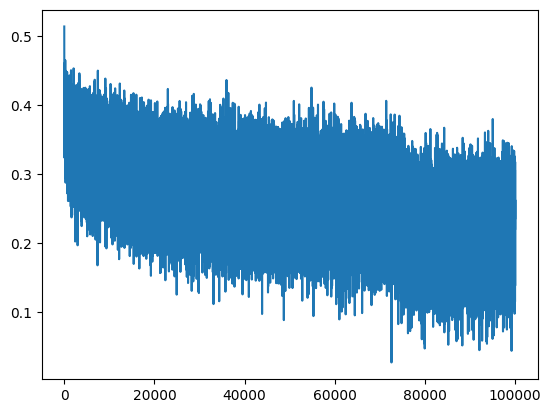

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [ ]:
# Switch state to use running_mean/var for inference
for layer in model.layers:
  layer.training = False

In [ ]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 200)
Batch1DNorm : (32, 4, 200)
Tanh : (32, 4, 200)
FlattenConsecutive : (32, 2, 400)
Linear : (32, 2, 200)
Batch1DNorm : (32, 2, 200)
Tanh : (32, 2, 200)
FlattenConsecutive : (32, 400)
Linear : (32, 200)
Batch1DNorm : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


layer 4 (      Tanh): mean -0.02, std 0.92, saturated: 54.94%
layer 8 (      Tanh): mean +0.03, std 0.98, saturated: 90.41%
layer 12 (      Tanh): mean -0.00, std 0.78, saturated: 48.05%


Text(0.5, 1.0, 'activation distribution')

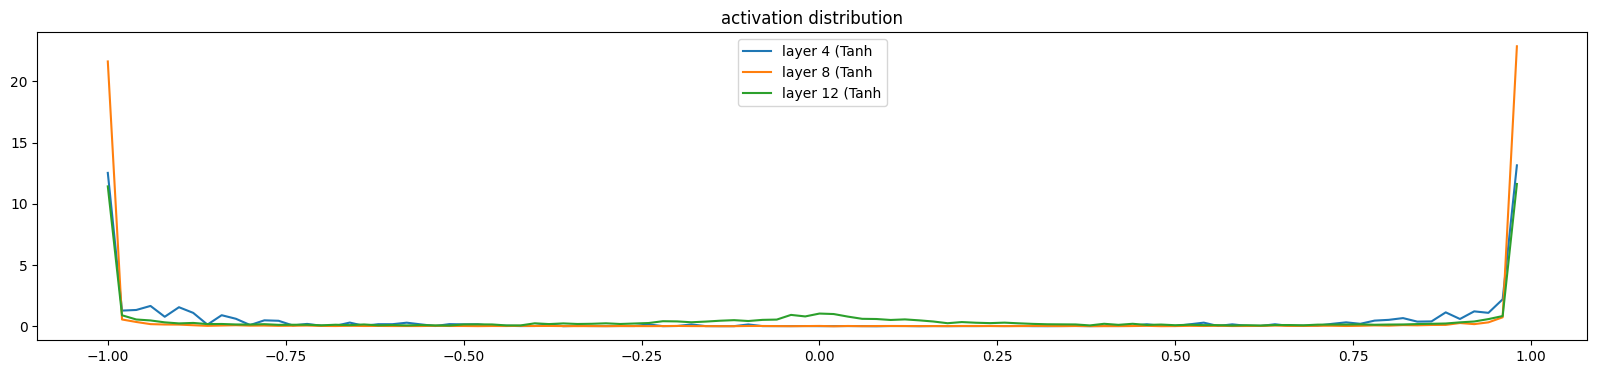

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 4 (      Tanh): mean +0.000006, std 1.793869e-03
layer 8 (      Tanh): mean +0.000006, std 2.561760e-03
layer 12 (      Tanh): mean -0.000106, std 5.247599e-03


Text(0.5, 1.0, 'gradient distribution')

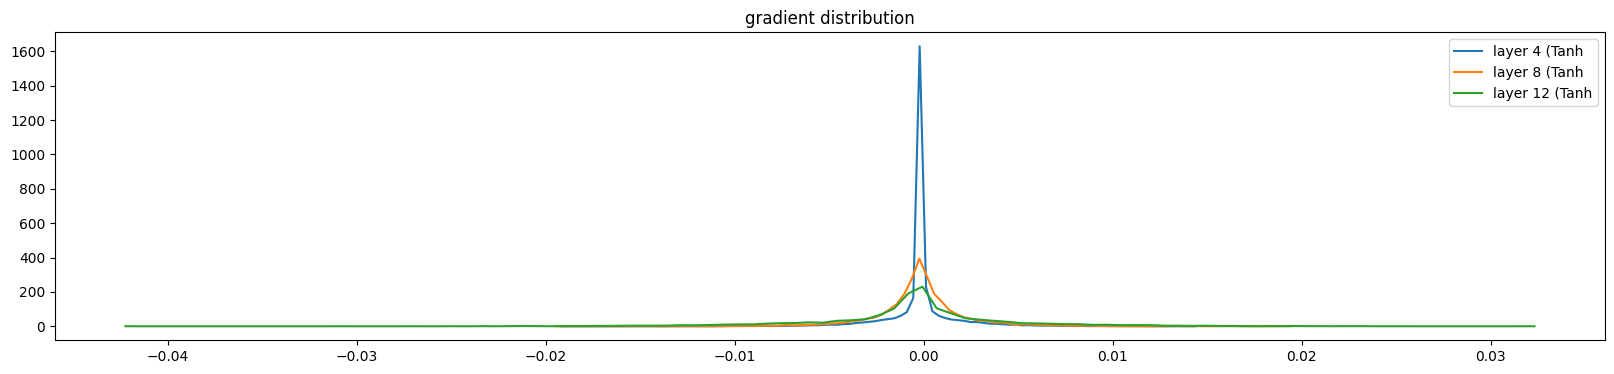

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(model.layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.001500 | std 2.104097e-02 | grad:data ratio 1.581602e-02
weight  (20, 200) | mean -0.000173 | std 1.109219e-02 | grad:data ratio 2.372907e-02
weight (400, 200) | mean +0.000012 | std 5.207386e-03 | grad:data ratio 2.942778e-02
weight (400, 200) | mean -0.000003 | std 4.925121e-03 | grad:data ratio 2.980104e-02
weight  (200, 27) | mean +0.000000 | std 2.121503e-02 | grad:data ratio 9.446806e-02


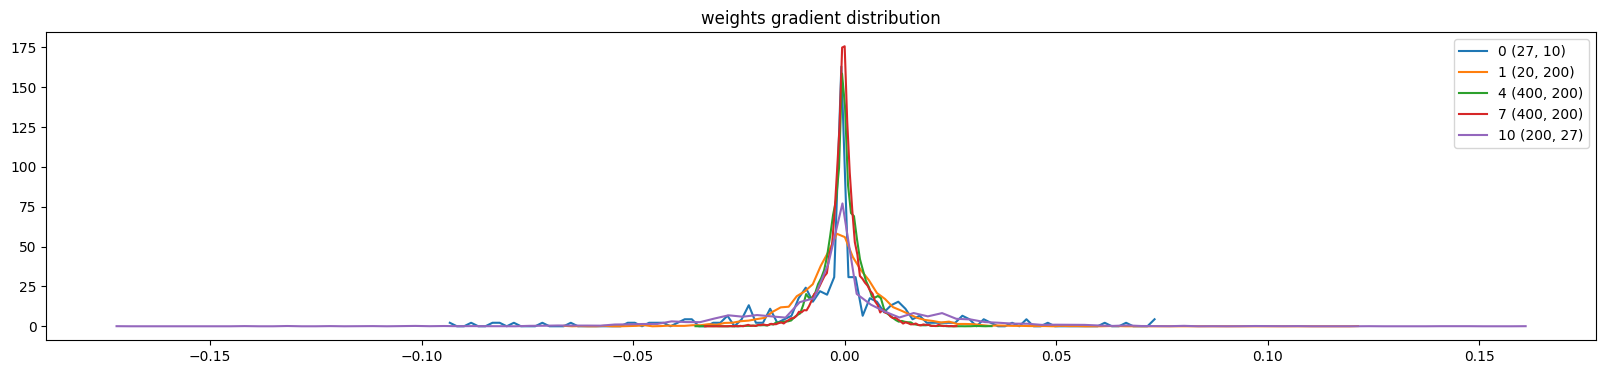

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(model.parameters()):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

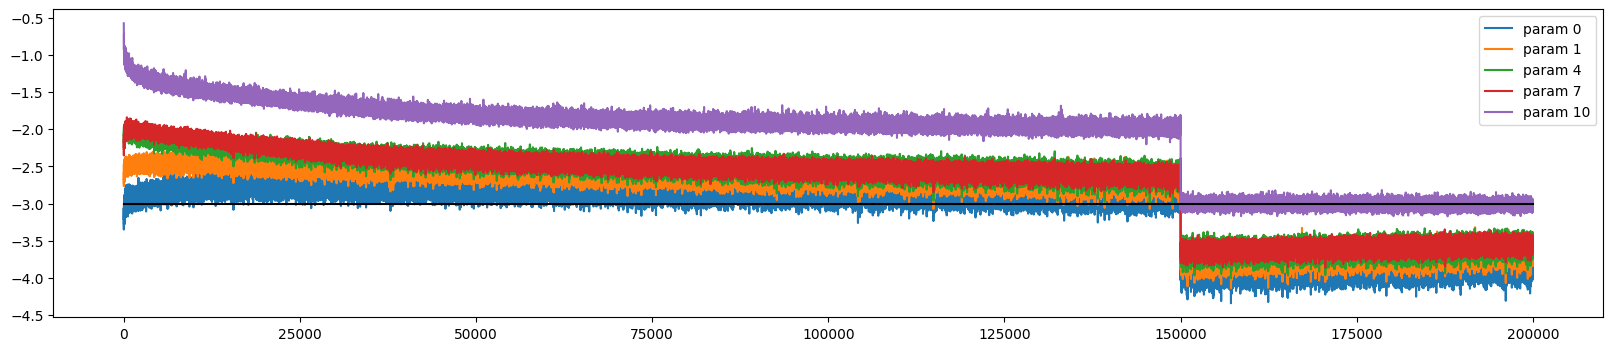

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(model.parameters()):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6530640125274658
val 2.0745224952697754


In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

cheri.
torin.
kylieghan.
brily.
zhanya.
xyla.
aracelis.
jaegen.
swayze.
bechaim.
daleth.
roze.
meera.
harter.
navin.
zacier.
rashod.
regid.
shahwa.
elaf.


# Research about Convolutions and how to implement them
- https://arxiv.org/pdf/1603.07285

In [ ]:
# Basic 2D Convolution
import numpy as np

input = np.array([
    [1, 2, 3, 0, 1],
    [0, 1, 2, 3, 1],
    [1, 2, 1, 0, 0],
    [0, 1, 3, 2, 1],
    [2, 0, 1, 1, 0]
])

kernel = np.array([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
])

- (1x1) + (2x0) + (3x-1) +
- (1×1) + (2×0) + (3×-1) +
- (0×1) + (1×0) + (2×-1) +
- (1×1) + (2×0) + (1×-1) =

------------
- 1 + 0 -3 +
- 0 + 0 -2 +
- 1 + 0 -1 =
------------

- (1 - 3 - 2 + 1 - 1) = **-4**
- The top left pixel would be -4


In [ ]:
output =  np.zeros((3,3))
for i in range(3): # vertivally
  for j in range(3): # horizontoally
    region = input[i:i+3, j:j+3]
    output[i, j] = np.sum(region * kernel)

print(output)

[[-4.  2.  4.]
 [-5. -1.  4.]
 [-2.  0.  4.]]


In [ ]:
# Padding
input = np.array([
    [1, 2, 3, 0, 1],
    [0, 1, 2, 3, 1],
    [1, 2, 1, 0, 0],
    [0, 1, 3, 2, 1],
    [2, 0, 1, 1, 0]
])

padded_input = np.pad(input, pad_width=1, mode='constant', constant_values=0)
print(padded_input)

[[0 0 0 0 0 0 0]
 [0 1 2 3 0 1 0]
 [0 0 1 2 3 1 0]
 [0 1 2 1 0 0 0]
 [0 0 1 3 2 1 0]
 [0 2 0 1 1 0 0]
 [0 0 0 0 0 0 0]]


In [ ]:
# Output size = ((Input size + 2 * padding - kernel size)/stride) + 1
# = ((5 + 2*1 - 3) / 1) + 1 = 5
output = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        region = padded_input[i:i+3, j:j+3]
        output[i, j] = np.sum(region * kernel)

print(output)

[[-3. -4.  0.  3.  3.]
 [-5. -4.  2.  4.  3.]
 [-4. -5. -1.  4.  5.]
 [-3. -2.  0.  4.  3.]
 [-1. -2. -2.  3.  3.]]


In [ ]:
# Strides
input.shape = (5, 5)
kernel.shape = (3, 3)
stride = 2

# Output size = ((5 - 3) / 2) + 1 = 2
output = np.zeros((2, 2))

for i in range(0, 5 - 2, 2):       # i = 0, 2
    for j in range(0, 5 - 2, 2):   # j = 0, 2
        region = input[i:i+3, j:j+3]
        output[i//2, j//2] = np.sum(region * kernel)

print(output)

[[-4.  4.]
 [-2.  4.]]


In [ ]:
# Rebuild dataset with smaller blocksize
block_size = 4

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 4]) torch.Size([182580])
torch.Size([22767, 4]) torch.Size([22767])
torch.Size([22799, 4]) torch.Size([22799])


In [ ]:
class Conv1D:
  def __init__(self, in_channels, out_channels, kernel_size, bias=True):
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size

    # (out_channels, in_channels, kernel_size)
    self.weight = torch.randn(out_channels, in_channels, kernel_size) / (in_channels * kernel_size) ** 0.5
    self.bias = torch.zeros(out_channels) if bias else None

  def __call__(self, x):
    # x: (B, T, C)
    B, T, C = x.shape
    K = self.kernel_size
    T_out = T - K + 1  # no padding
    out = torch.zeros(B, T_out, self.out_channels)

    for b in range(B):
      for t in range(T_out):
        for oc in range(self.out_channels):
          conv_sum = 0.0
          for kc in range(K):
            conv_sum += (x[b, t + kc] * self.weight[oc, :, kc]).sum()
          if self.bias is not None:
            conv_sum += self.bias[oc]
          out[b, t, oc] = conv_sum

    self.out = out
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
n_embd = 10
n_hidden = 50

model = Sequential([
  Embedding(vocab_size, n_embd),
  Conv1D(n_embd, n_hidden, kernel_size=2),
  Batch1DNorm(n_hidden), Tanh(),
  Conv1D(n_hidden, n_hidden, kernel_size=2),
  Batch1DNorm(n_hidden), Tanh(),
  Conv1D(n_hidden, n_hidden, kernel_size=2),
  Batch1DNorm(n_hidden), Tanh(),

  Flatten(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum((p.nelement() for p in parameters)))
for p in parameters:
  p.requires_grad = True

13097


In [ ]:
max_steps = 1000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for layer in model.layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 50 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

      0/   1000: 2.9752
     50/   1000: 2.6954
    100/   1000: 2.5654
    150/   1000: 2.7840
    200/   1000: 2.2890
    250/   1000: 2.2428
    300/   1000: 2.5510
    350/   1000: 2.5051
    400/   1000: 2.3125
    450/   1000: 2.4486
    500/   1000: 2.4545
    550/   1000: 2.7027
    600/   1000: 2.2482
    650/   1000: 2.0981
    700/   1000: 2.0307
    750/   1000: 2.4365
    800/   1000: 2.4341
    850/   1000: 2.2479
    900/   1000: 2.2239
    950/   1000: 2.5286


In [ ]:
# Switch state to use running_mean/var for inference
for layer in model.layers:
  layer.training = False

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.7983245849609375
val 2.7911839485168457


In [ ]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mimodne.
dalynmoyvynnomzaicos.
syslpmardanllo.
risukzynr.
ttimrnai.
szeog.
zhinnnlo.
erikandilisn.
lael.
dreiandivjamanday.
smyliarnaosqsaprimuzlrojthalanmaxthnwir.
likamifbeirberareclid.
cuna.
aza.
mishalyssalanpdalucek.
zbmarty.
sesgtonaxaptadxeretandien.
sxeelenyj.
mrlof.
raodtrelkjhtrdom.


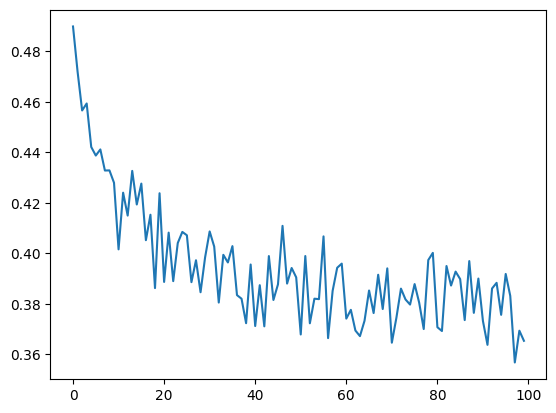

In [ ]:
plt.plot(torch.tensor(lossi).view(-1, 10).mean(1))

- Observations:
  - We are limited by our own implementations, due to not utilizing the CUDA Kernels, meaning we would be better off using Torch!

In [3]:
import torch.nn as nn

# wrapper
class RearrangeInput(nn.Module):
  def forward(self, x):
    return x.permute(0,2,1)

In [48]:
n_embd = 10
n_hidden = 68
block_size = 4

model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    RearrangeInput(),
    nn.Conv1d(n_embd, n_hidden, kernel_size=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.Conv1d(n_hidden, n_hidden, kernel_size=2),
    nn.BatchNorm1d(n_hidden),
    nn.Tanh(),

    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(n_hidden, vocab_size),
)

x = torch.randint(0, vocab_size, (1, block_size))
print(f"Input shape: {x.shape}")

for layer in model:
    x = layer(x)
    print(f"{layer.__class__.__name__}: {x.shape}")

Input shape: torch.Size([1, 4])
Embedding: torch.Size([1, 4, 10])
RearrangeInput: torch.Size([1, 10, 4])
Conv1d: torch.Size([1, 68, 3])
BatchNorm1d: torch.Size([1, 68, 3])
Tanh: torch.Size([1, 68, 3])
Conv1d: torch.Size([1, 68, 2])
BatchNorm1d: torch.Size([1, 68, 2])
Tanh: torch.Size([1, 68, 2])
AdaptiveAvgPool1d: torch.Size([1, 68, 1])
Flatten: torch.Size([1, 68])
Linear: torch.Size([1, 27])


In [49]:
parameters = list(model.parameters()) # wrap parameters in list, or else nothing will happen!
print(f"Parameters: {sum((p.nelement() for p in parameters))}")

Parameters: 13149


In [24]:
# Debugging: to see if the model can overfit
# tiny_X = Xtr[:10]
# tiny_Y = Ytr[:10]
# for i in range(1000):
#     logits = model(tiny_X)
#     loss = F.cross_entropy(logits, tiny_Y)

#     for p in parameters:
#         p.grad = None
#     loss.backward()
#     for p in parameters:
#         p.data += -0.1 * p.grad

#     if i % 100 == 0:
#         print(f'{i}: {loss.item()}')

0: 3.260704755783081
100: 1.1450409889221191
200: 0.819637656211853
300: 0.6710727214813232
400: 0.5768429636955261
500: 0.5095534324645996
600: 0.4579276442527771
700: 0.4176017642021179
800: 0.3850533962249756
900: 0.35865193605422974


In [50]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2892
  10000/ 200000: 2.6858
  20000/ 200000: 2.4012
  30000/ 200000: 2.4089
  40000/ 200000: 1.8718
  50000/ 200000: 2.1112
  60000/ 200000: 1.9579
  70000/ 200000: 2.4138
  80000/ 200000: 2.0052
  90000/ 200000: 2.3469
 100000/ 200000: 1.9357
 110000/ 200000: 1.9128
 120000/ 200000: 2.1629
 130000/ 200000: 1.7397
 140000/ 200000: 2.6332
 150000/ 200000: 2.3475
 160000/ 200000: 2.3325
 170000/ 200000: 2.3239
 180000/ 200000: 2.0574
 190000/ 200000: 2.1893


In [51]:
@torch.no_grad()
def split_loss(split):
  model.eval()
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]

  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.048515558242798
val 2.0973525047302246


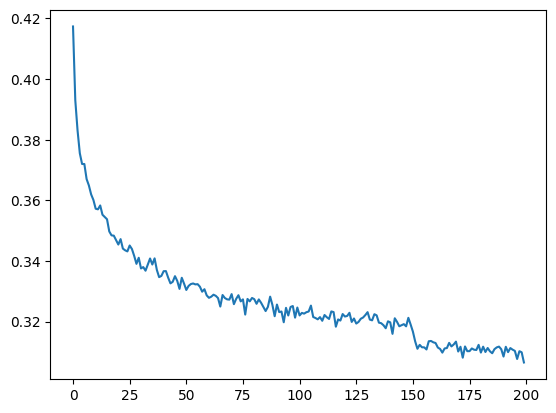

In [52]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [53]:
# sample from the model
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

avian.
avion.
grick.
yuston.
monter.
urielling.
brigh.
sulvin.
suhdinghuw.
evertin.
ivian.
kyndershawn.
elichinghuwgellen.
marvinshun.
annah.
kinghumgan.
eliah.
aver.
wynnellah.
hayson.
